### Import the libraries and modules we will be using

In [1]:
import matplotlib.pyplot as plt
import pydicom as dicom
import matplotlib
import os, os.path
import imageio
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import pyvista as pv
import math
import copy

### Returns the names in an array of the files in a given path

In [2]:
def file_names(directory_path, file_type):
    '''file path XXXX'''
    all_files = os.listdir(directory_path)
    file_names = [file for file in all_files if file.lower().endswith('.' + file_type)]
    return file_names

In [3]:
directory_path = 'manifest-1729153551742/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30178/3000566.000000-NA-03192/'
file_type = 'dcm'

In [4]:
files = file_names(directory_path, file_type)
files.sort()

### Opens the files and accesses the data of the voxels in an array format. Merges the arrays into a 3D array

In [5]:
three_d_array = []
for file in files:
    filename=file.replace('.dcm', '') +'.png'
    image_path = '{}/{}'.format(directory_path,file)
    ds = dicom.dcmread(image_path)
    three_d_array.append(ds.pixel_array)
combined_array = np.stack(three_d_array, axis=1)

In [6]:
imgvals = combined_array
imgvals.shape

(512, 133, 512)

### We observe the values of the voxels

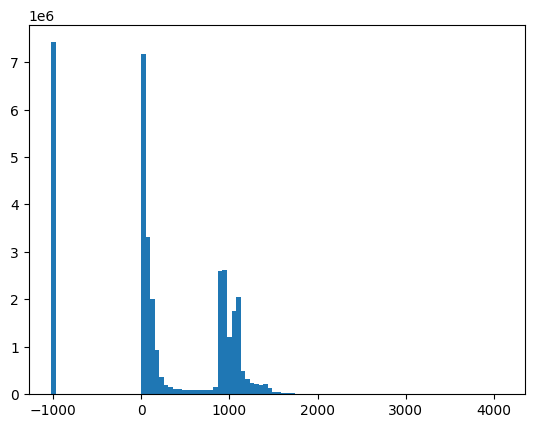

In [7]:
plt.hist(np.ndarray.flatten(imgvals),bins=100)
plt.show()

### We want to obtain a binary grid, so we identify the "dull" "noise" voxels with zero

In [8]:
imgvals = np.where(imgvals > 500, 1, 0)

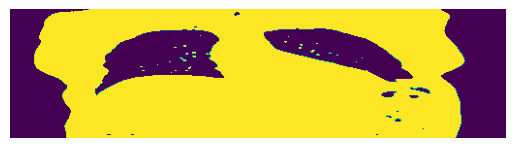

In [9]:
plt.imshow(imgvals[200,:,:])
plt.axis('off')
plt.show()

### We apply marching cubes, which receives the voxels position and vector field, as well as an iso_value which determines a surface that separates the values 0 and 1

In [10]:
# Volume data
volume_data = imgvals

# Isosurface value
iso_value = 0.5

# Extract the isosurface
vertices, faces, normals, values = measure.marching_cubes(volume_data, iso_value)

### Visualization

In [67]:
# Adjust faces array for PyVista
faces_pv = np.column_stack([np.full(len(faces), 3), faces])

# Create a PyVista mesh
mesh = pv.PolyData(vertices, faces_pv)

# Visualize the mesh
mesh.plot()

Widget(value='<iframe src="http://localhost:44367/index.html?ui=P_0x72f0fd5c7f20_6&reconnect=auto" class="pyvi…

In [11]:
print(vertices)

[[ 67.5 132.  243. ]
 [ 68.  132.  242.5]
 [ 68.  131.5 243. ]
 ...
 [459.5  50.  242. ]
 [459.5  50.  243. ]
 [459.5  50.  246. ]]


In [12]:
print(faces)

[[      2       1       0]
 [      4       3       0]
 [      0       3       2]
 ...
 [1121729 1125324 1121646]
 [1125325 1121732 1121651]
 [1121732 1125325 1121652]]


In [13]:
faces[0]

array([2, 1, 0], dtype=int32)

The faces array is composed of indices that correspond to the vertices array. Each triplet in the faces array represents a triangle in the mesh:

    Each row in the faces array contains three values.

    These values are indices pointing to the vertices that form a triangle.

So, for a given face [i, j, k], i, j, and k are indices into the vertices array, specifying the coordinates of the triangle's corners.

## Filtration Code

In [14]:
def height_of_vertex(direction, point):
    height = 0
    for n in list(range(3)):
        height_squared = direction[n] * point[n]
    return math.sqrt(height_squared)    

### Our two basic data structures to keep track of the information of the vertices

In [15]:
def vertex_dictionary(direction, vertices):
    n = 0
    dictionary = []
    for vertex in vertices:
        dictionary.append({'location': n, 'height': height_of_vertex(direction, vertex), 'coordinates': vertex})
        n+=1
    return dictionary

In [16]:
# Python 3.7 and above
def faces_dictionary(vlist, faces):
    n = 0
    dictionary = []
    for face in faces:
        face_height = max([vlist[face[i]]['height'] for i in list(range(3))])
        dictionary.append({'height': face_height, 'coordinates': face})
        n+=1
    return dictionary

In [17]:
test_direction= [0,0,1]
test_point= [1,1,1]
height_of_vertex(test_direction, test_point)

1.0

In [18]:
new_vertices = vertex_dictionary(test_direction, vertices)

In [19]:
len(new_vertices)

1125326

In [20]:
len(faces)

2243814

In [21]:
new_vertices[1000]

{'location': 1000,
 'height': 16.881943016134134,
 'coordinates': array([ 73.5, 128. , 285. ], dtype=float32)}

In [22]:
new_faces = faces_dictionary(new_vertices, faces)

In [23]:
for i in list(range(9)):
    print(new_faces[i])

{'height': 15.588457268119896, 'coordinates': array([2, 1, 0], dtype=int32)}
{'height': 15.620499351813308, 'coordinates': array([4, 3, 0], dtype=int32)}
{'height': 15.620499351813308, 'coordinates': array([0, 3, 2], dtype=int32)}
{'height': 15.652475842498529, 'coordinates': array([6, 5, 4], dtype=int32)}
{'height': 15.652475842498529, 'coordinates': array([4, 5, 3], dtype=int32)}
{'height': 15.684387141358123, 'coordinates': array([8, 7, 6], dtype=int32)}
{'height': 15.684387141358123, 'coordinates': array([6, 7, 5], dtype=int32)}
{'height': 15.716233645501712, 'coordinates': array([10,  9,  8], dtype=int32)}
{'height': 15.716233645501712, 'coordinates': array([8, 9, 7], dtype=int32)}


### We sort the faces and vertices to apply our filtration algorithm

In [24]:
new_faces.sort(key=lambda x: x['height'])

In [25]:
for i in list(range(9)):
    print(new_faces[i])

{'height': 0.7071067811865476, 'coordinates': array([311171, 308480, 308478], dtype=int32)}
{'height': 0.7071067811865476, 'coordinates': array([311172, 308480, 311171], dtype=int32)}
{'height': 0.7071067811865476, 'coordinates': array([311172, 308492, 308480], dtype=int32)}
{'height': 0.7071067811865476, 'coordinates': array([311184, 308492, 311172], dtype=int32)}
{'height': 0.7071067811865476, 'coordinates': array([311184, 308498, 308492], dtype=int32)}
{'height': 0.7071067811865476, 'coordinates': array([311192, 308498, 311184], dtype=int32)}
{'height': 0.7071067811865476, 'coordinates': array([311192, 308505, 308498], dtype=int32)}
{'height': 0.7071067811865476, 'coordinates': array([311198, 308505, 311192], dtype=int32)}
{'height': 0.7071067811865476, 'coordinates': array([311198, 308514, 308505], dtype=int32)}


In [26]:
new_vertices.sort(key=lambda x: x['height'])

### The faces were matched with vertices by their location in the unsorted array, so we need to make a hashmap to relate them to their old position.

In [45]:
vertices_new_location = {index: d['location'] for index, d in enumerate(new_vertices)}

In [47]:
print(vertices_new_location[10])

340816


In [52]:
hashmap = {v: k for k, v in vertices_new_location.items()}

In [27]:
clone_faces = new_faces[:100]
clone_vertices = new_vertices[:100]

In [28]:
print(clone_vertices[:10])

[{'location': 340748, 'height': 0.0, 'coordinates': array([239.5,   1. ,   0. ], dtype=float32)}, {'location': 340749, 'height': 0.0, 'coordinates': array([239.5,   0. ,   0. ], dtype=float32)}, {'location': 340758, 'height': 0.0, 'coordinates': array([239.5,   2. ,   0. ], dtype=float32)}, {'location': 340765, 'height': 0.0, 'coordinates': array([239.5,   3. ,   0. ], dtype=float32)}, {'location': 340774, 'height': 0.0, 'coordinates': array([239.5,   4. ,   0. ], dtype=float32)}, {'location': 340792, 'height': 0.0, 'coordinates': array([239.5,   5. ,   0. ], dtype=float32)}, {'location': 340800, 'height': 0.0, 'coordinates': array([239.5,   6. ,   0. ], dtype=float32)}, {'location': 340804, 'height': 0.0, 'coordinates': array([239.5,   7. ,   0. ], dtype=float32)}, {'location': 340808, 'height': 0.0, 'coordinates': array([239.5,   8. ,   0. ], dtype=float32)}, {'location': 340813, 'height': 0.0, 'coordinates': array([239.5,   9. ,   0. ], dtype=float32)}]


In [29]:
vertices_height = [vertex['height'] for vertex in new_vertices]
faces_height = [face['height'] for face in new_faces]

### This creates a filtration with output the length of slice of the ordered arrays

In [30]:
def create_filtration(vertices, faces):
    filtration = []
    previous_value = vertices[0]
    m = 0
    for i in range(1, len(vertices)):
        for j in range(m, len(faces)):
            if faces[j] <= previous_value:
                j += 1
                m = j
            else:
                break
        if vertices[i] != previous_value:
            filtration.append([i, j])
            previous_value = vertices[i]
        
    filtration.append([len(vertices), j])
    return filtration

In [31]:
ordered_list = [1, 1, 2, 2, 3, 3, 3, 4, 4]
ordered_list_2 = [1,1,1,1,1,2,3,3,3,3,3,4,4,4,4,4]
filtration = create_filtration(vertices_height, faces_height)

In [32]:
def nth_complex(vertices, faces, n):
    return (vertices[:n[0]], faces[:n[1]])

In [33]:
coord_vertices = [vertex['coordinates'].tolist() for vertex in new_vertices]
coord_faces = [face['coordinates'].tolist() for face in new_faces]

In [51]:
print(coord_faces[1])

[311172, 308480, 311171]


In [53]:
reordered_faces = [[hashmap[element] for element in sublist] for sublist in coord_faces]



In [43]:
print(len(filtration))

1023


In [111]:
vertices, faces = nth_complex(coord_vertices, reordered_faces, filtration[300])

## Note we can have the case where the set of faces is empty in which case pyvista generates an error.

In [86]:
print(faces)
print(vertices)

[]
[[239.5, 1.0, 0.0], [239.5, 0.0, 0.0], [239.5, 2.0, 0.0], [239.5, 3.0, 0.0], [239.5, 4.0, 0.0], [239.5, 5.0, 0.0], [239.5, 6.0, 0.0], [239.5, 7.0, 0.0], [239.5, 8.0, 0.0], [239.5, 9.0, 0.0], [239.5, 10.0, 0.0], [239.5, 11.0, 0.0], [239.5, 12.0, 0.0], [239.5, 13.0, 0.0], [239.5, 14.0, 0.0], [239.5, 15.0, 0.0], [239.5, 16.0, 0.0], [239.5, 17.0, 0.0], [239.5, 18.0, 0.0], [239.5, 19.0, 0.0], [239.5, 20.0, 0.0], [239.5, 21.0, 0.0], [239.5, 22.0, 0.0], [239.5, 23.0, 0.0], [239.5, 24.0, 0.0], [239.5, 25.0, 0.0], [239.5, 26.0, 0.0], [239.5, 27.0, 0.0], [239.5, 28.0, 0.0], [239.5, 29.0, 0.0], [239.5, 30.0, 0.0], [239.5, 31.0, 0.0], [239.5, 32.0, 0.0], [240.0, 32.5, 0.0], [240.5, 33.0, 0.0], [241.0, 33.5, 0.0], [242.0, 3.5, 0.0], [241.5, 4.0, 0.0], [241.5, 5.0, 0.0], [242.0, 5.5, 0.0], [241.5, 34.0, 0.0], [242.0, 34.5, 0.0], [243.0, 3.5, 0.0], [242.5, 5.0, 0.0], [243.0, 4.5, 0.0], [242.5, 35.0, 0.0], [243.0, 35.5, 0.0], [243.5, 4.0, 0.0], [243.5, 36.0, 0.0], [243.5, 37.0, 0.0], [244.0, 37.5, 

In [112]:
# Adjust faces array for PyVista
faces_pv = np.column_stack([np.full(len(faces), 3), faces])

# Create a PyVista mesh
mesh = pv.PolyData(vertices, faces_pv)

# Visualize the mesh
mesh.plot()

Widget(value='<iframe src="http://localhost:44367/index.html?ui=P_0x72f0f4244440_22&reconnect=auto" class="pyv…